<a href="https://colab.research.google.com/github/HughYau/Research-with-Python/blob/main/Gini%20and%20Lorenz%20curve%20Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import lognorm,pareto,norm,weibull_min
import scipy.integrate as integrate
from scipy.special import gamma
from scipy.optimize import fsolve
from matplotlib.ticker import MaxNLocator
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [ ]:
sheet = np.array([[ 4747.3, 10887.4, 17631. , 26937.4, 50968. ],
       [ 5221.2, 11894. , 19320.1, 29437.6, 54543.5],
       [ 5528.7, 12898.9, 20924.4, 31990.4, 59259.5],
       [ 5958.4, 13842.8, 22495.3, 34546.8, 64934. ],
       [ 6440.5, 14360.5, 23188.9, 36471.4, 70639.5],
       [ 7380.4, 15777. , 25034.7, 39230.5, 76400.7],
       [ 7868.8, 16442.7, 26248.9, 41171.7, 80293.8]])#14-20年收入五等分数据

gini = np.array([[0.479, 0.473, 0.485, 0.487, 0.484, 0.491, 0.49 , 0.481, 0.477,
        0.474, 0.473, 0.469, 0.462, 0.465, 0.467, 0.468, 0.465,0.468]]) #12-20基尼系数

#洛伦兹曲线拟合方程1
def lorenz_curve1(a,x):
    return x-x*(1-x)**a

#洛伦兹曲线拟合方程2
def lorenz_curve2(a,x):
    return (np.exp(a*x)-1)/(np.exp(a)-1)

In [ ]:
class Inequality(object):
    def __init__(self,data,fun = lorenz_curve1):
        self.data,self.fun = data,fun
        y = np.empty(self.data.shape)
        self.mean = np.mean(self.data)
        for j in range(5):
            y[j] = np.sum(self.data[:j+1])*0.2/self.mean
        self.y = y
    
    def data_approx(self,method):#通过五等分数据估算分布
        if method == 'lognorm':#对数正态
            func = lognorm
            theta0 = 0.5
        elif method == 'pareto':#帕累托
            func = pareto
            theta0 = 1.5
        elif method == 'weibull':#威布尔，III型极值分布
            func = weibull_min
            theta0 = 2
 
        def fun(x):
            result = np.empty(5)
            for i in range(1,6):
                xtimespdf = lambda a:a*func(x).pdf(a)
                result[i-1] = integrate.quad(xtimespdf,0,func.ppf(0.2*i,x))[0]/func(x).mean()   
            return result - self.y
        res = least_squares(fun,theta0,loss = 'linear',verbose = 2)
        if method == 'lognorm':
            gini = 2*norm.cdf(res.x)-1
        elif method == 'pareto':
            gini = 1/(2*res.x-1)
        elif method == 'weibull':
            gini = 1-2**(-1/res.x)
            
        return func(res.x),res,gini
    
    def curve_fit(self):#通过五等分数据以及给定的洛伦兹曲线形式估算分布
        theta0 = 0.5
        def difffun(a):
            return self.fun(a,0.2*np.arange(1,6))-self.y
        res = least_squares(difffun,theta0,loss = 'linear',verbose = 0)
        return res
                 
    def gini(self):
        a = self.curve_fit().x
        def fun(x):
            return self.fun(a,x)
        return 1-2*integrate.quad(fun,0,1)[0]
    
    def plot(self):
        fig, ax = plt.subplots(figsize=(10,6))
        ax.scatter(0.2*np.arange(1,6),self.y,label = '五等分数据点')
        ax.plot(np.linspace(0,1,100),np.linspace(0,1,100),label = '绝对平等线', linestyle = ':' )
        plt.plot(np.linspace(0,1,100),self.fun(self.curve_fit().x,np.linspace(0,1,100)),label = '拟合曲线')
        ax.legend()

In [ ]:
case = Inequality(data = sheet[5])
test = case.data_approx(method = 'lognorm')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5436e-02                                    1.12e-01    
       1              2         1.3500e-04      1.53e-02       2.75e-01       2.87e-03    
       2              3         1.2325e-04      1.18e-05       8.29e-03       3.10e-05    
       3              4         1.2324e-04      1.37e-09       8.99e-05       3.84e-07    
       4              5         1.2324e-04      2.11e-13       1.11e-06       4.83e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 1.5436e-02, final cost 1.2324e-04, first-order optimality 4.83e-09.


In [ ]:
test[1]

 active_mask: array([0.])
        cost: 0.00012324396117275072
         fun: array([ 7.04803918e-03,  8.61466201e-03,  3.93148245e-03, -1.03510439e-02,
       -1.37811984e-12])
        grad: array([4.8286483e-09])
         jac: array([[-0.10656709],
       [-0.23312833],
       [-0.34669248],
       [-0.39826234],
       [ 0.        ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 4.828648301515026e-09
      status: 1
     success: True
           x: array([0.78321229])

In [ ]:
test[2]#通过数据拟合出的分布计算基尼系数

array([0.56649754])

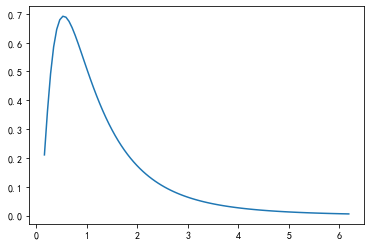

In [ ]:
func = test[0]
x = np.linspace(func.ppf(0.01),
                func.ppf(0.99), 100)
plt.plot(x,func.pdf(x))

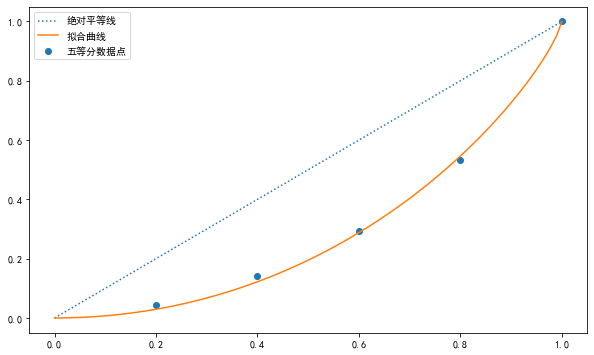

In [ ]:
case.plot()

In [ ]:
case.gini()#通过数据拟合出的洛伦兹曲线计算基尼系数

0.4302428002805564

In [ ]:
#通过基尼系数估计分布
def gini_approx(gini,method):
    if method == 'lognorm':
        func = lambda x:2*norm.cdf(x)-1-gini
        sigma = fsolve(func,2)
        print(sigma)
        return lognorm(sigma)
    elif method == 'pareto':
        func = lambda x:1/(2*x-1)-gini
        alpha = fsolve(func,2)
        print(alpha)
        return pareto(alpha)
    elif method == 'weibull':
        func = lambda x:1-2**(-1/x)-gini
        beta = fsolve(func,2)
        print(beta)
        return weibull_min(beta)

[1.10157325]


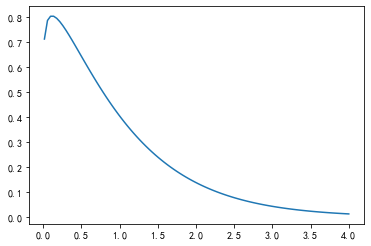

In [ ]:
test1 = gini_approx(gini = 0.467,method = 'weibull')
x = np.linspace(test1.ppf(0.01),
                test1.ppf(0.99), 100)
plt.plot(x,test1.pdf(x))

In [ ]:
for i in range(5):
    a = integrate.quad(lambda x:5*x*test1.pdf(x),test1.ppf(0.2*i),test1.ppf(0.2*(i+1)))
    print(a[0])

0.12963452764342645
0.39477314210369746
0.722465667274827
1.1993295554449177
2.376092686067955


In [ ]:
a

(0.025926905518148826, 6.397864556600817e-09)

In [ ]:
test1.ppf(0.9)

array([2.13214486])

(array([5., 7., 3., 5., 3., 2., 3., 1., 0., 1.]),
 array([0.01338397, 0.29994555, 0.58650713, 0.87306871, 1.15963029,
        1.44619187, 1.73275345, 2.01931503, 2.30587661, 2.59243819,
        2.87899977]),
 <BarContainer object of 10 artists>)

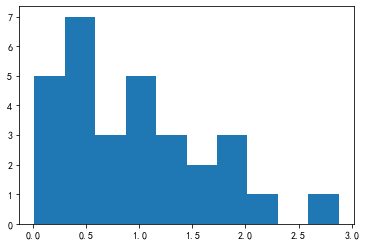

In [ ]:
ep = 1.0368505876615817*np.random.weibull(1.10157325,30)
plt.hist(ep)

In [ ]:
1/gamma(1+1/1.10157325)#验证Weibull均值计算

1.0368505876615817

In [ ]:
ep

array([0.75880569, 0.40874197, 0.470598  , 0.25215749, 0.49525188,
       0.32785275, 0.46331132, 0.38502471, 0.08193357, 0.65806658,
       0.61587131, 0.66841024, 0.64607025, 0.73605277, 1.71949241,
       0.12095518, 0.46916368, 0.06988415, 0.52288496, 0.5611389 ,
       2.34203188, 0.24930087, 2.41516953, 0.34948344, 2.23983152,
       1.37045345, 1.48534204, 1.00055135, 0.13465829, 2.84543818])